# Sinkhorn Distence 1D

Consider $\mu = \sum a_i \delta_i$ and $\nu = \sum b_i \delta_i$ on $\Omega$
The Wasserstein distence:
$$W_p^p (\mu, \nu) = \int c(x,y) \ d \gamma$$
Here $\gamma$ on $\Omega^2$ and have marginals $\mu$ and $\nu$.

The discrete form:

Define cost matrix $M = c(x,y)^p$,
$$W_p^p = \min_{T\in U(a,b)} =<T, M>$$
Here $U(a,b) = \{T\in \mathbb{R}^{n\times m}| T\mathbf{1}_m = a, T^T\mathbf{1}_n=b \}$

The sinkhorn distence:
for $\lambda > 0$,
$$S^\lambda_M (f,g) = <P^\lambda, M>$$
where
$$P^\lambda = {argmin}_{P\in U(a,b)} <P,M> + \frac{1}{\lambda} \sum P_{i,j}log{P_{i,j}}$$

In [1]:
using PyPlot
using PyCall
using LinearAlgebra
ot = pyimport("ot")

PyObject <module 'ot' from '/Users/lida/.julia/conda/3/lib/python3.7/site-packages/ot/__init__.py'>

In [2]:
function gauss_func(t, b, c)
    y = exp.(-(t.-b).^2 ./ (2*c^2));
    return y
end

function sin_func(t, omega, phi)
    return sin.(2*pi*omega*(t .- phi));
end

function ricker_func(t, t0, sigma)
    t = t.-t0;
    f = (1 .- t.^2 ./ sigma.^2) .* exp.(- t.^2 ./ (2 .* sigma.^2));
    return f
end

ricker_func (generic function with 1 method)

In [3]:
function cost_func_1D(N)
    x = range(0, step=1, length=N)
    # Build loss matrix
    M = zeros(N,N)
    for i = 1:N
        for j = 1:N
            M[i,j] = (x[i] - x[j])^2
        end
    end
    return M
end

cost_func_1D (generic function with 1 method)

## Example for Gaussian

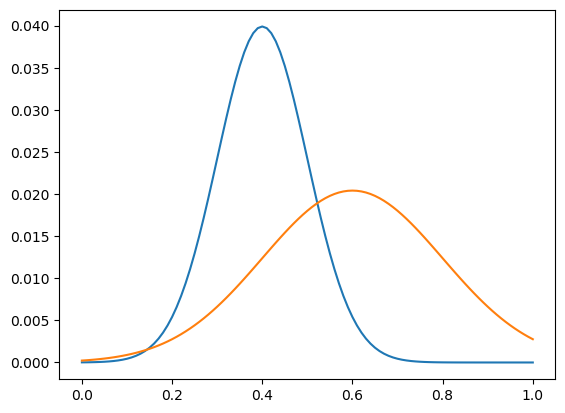

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x104121e2e8>
 PyObject <matplotlib.lines.Line2D object at 0x104121e438>

In [4]:
N = 101
x = range(0, stop=1, length=N)
r = gauss_func(x, 0.4, 0.1)
c = gauss_func(x, 0.6, 0.2)
# r[1:3] .= 0
r = r ./ norm(r,1)
c = c ./ norm(c,1)
figure
plot(x,r,x,c)
# norm(c,1)

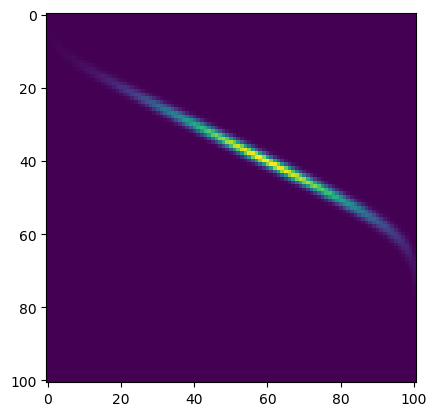

442.29357651068796

In [5]:
M = cost_func_1D(N);

# using Python Sinkhorn code"
lambd = 5
Gs = ot.sinkhorn(r, c, M, lambd, verbose=true, stopThr=1e-9)
figure
imshow(Gs)
sum(Gs .* M)

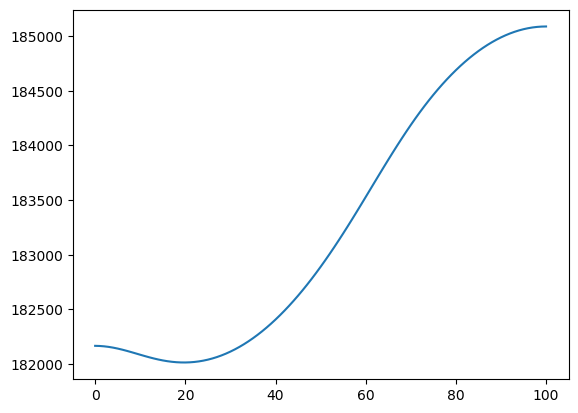

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13b61b588>

In [6]:
# Compute exact gradient
T = Gs;

n, m = size(T)
T_bar = T[1:n, 1:(m-1)]

L = T .* M
L_bar = L[1:n, 1:(m-1)]

D1 = diagm(T * ones(m))
D2 = diagm(T_bar' * ones(n))
D2 = inv(D2)

H = D1 - T_bar * D2 * T_bar'

f = -1*L*ones(m) + T_bar * D2 * L_bar' * ones(n)

g = inv(H) * f

G = g - ones(n) * g' * ones(n);
plot(G)

In [7]:
# Given: r, c, M, lambda
r = gauss_func(x, 0.4, 0.1)
c = gauss_func(x, 0.6, 0.2)
# r[1:3] .= 0
r = r ./ norm(r,1)
c = c ./ norm(c,1)
M = cost_func(101);
lambda = 2000
numItermax = 1000
stopThr = 1e-6

T = 0 .* M
I = findall(x->x>0, r)
N = length(r)
Ns = length(I)
r = r[I]
M1 = M[I,:]
K = exp.(-1 .* lambda .* M1)

u = ones(Ns) ./ Ns
v = ones(N) ./ N
u0 = ones(Ns) ./ Ns

K_tilde = diagm(1 ./ r) * K;

numIter = 1
e = stopThr
while (numIter < numItermax) && (e >= stopThr)
    v = c ./ (K' * u)
    u = 1 ./ (K_tilde * v)
    
    e = norm(u0-u)
    numIter += 1
    u0[:] = u[:]
#     println(numIter)
end
v = c ./ (K' * u)

T[I,:] = diagm(u) * K * diagm(v)
sum(T.*M)
alpha = zeros(N)
alpha[I] = -1/lambda .* log.(u)  + (log.(u)'*ones(length(u)))./(lambda*length(u)) .* ones(length(u))

UndefVarError: UndefVarError: cost_func not defined

In [8]:
function sinkhorn_basic(r, c, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)
    T = 0 .* M
    I = findall(x->x>0, r)
    N = length(r)
    Ns = length(I)
    r = r[I]
    M1 = M[I,:]
    K = exp.(-1 .* lambda .* M1)
    
    u = ones(Ns) ./ Ns
    v = ones(N) ./ N
    u0 = ones(Ns) ./ Ns

    K_tilde = diagm(1 ./ r) * K;

    numIter = 1
    e = stopThr
    while (numIter <= numItermax) && (e >= stopThr)
        v = c ./ (K' * u)
        u = 1 ./ (K_tilde * v)

        e = norm(u0-u)
        numIter += 1
        u0[:] = u[:]
#         println(numIter)
    end
    v = c ./ (K' * u)

    T[I,:] = diagm(u) * K * diagm(v)
    d = sum(T.*M)
    alpha = zeros(N)
    alpha[I] = -1/lambda .* log.(u)  + (log.(u)'*ones(length(u)))./(lambda*length(u)) .* ones(length(u))
    
    if verbose == true
        println("Iteration number: ", numIter-1)
        println("Error: ", e)
    end
    return T, alpha, d
end

sinkhorn_basic (generic function with 1 method)

In [9]:
T, a, d = sinkhorn_basic(r, c, M; lambda=1e-1, numItermax = 4000, stopThr = 1e-8, verbose=true);

Iteration number: 1445
Error: 7.105644194727685e-15


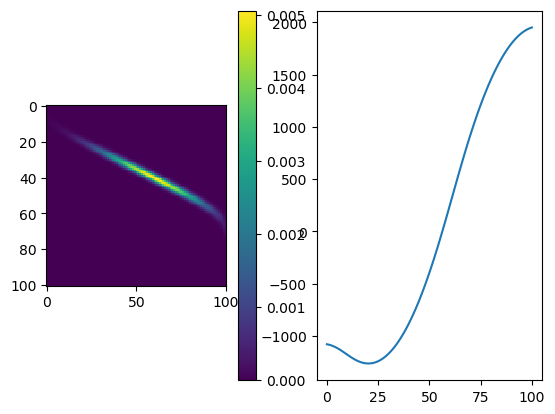

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1041499320>

In [10]:
figure;
subplot(121); imshow(T); colorbar()
subplot(122); plot(a)

## Example for Ricker

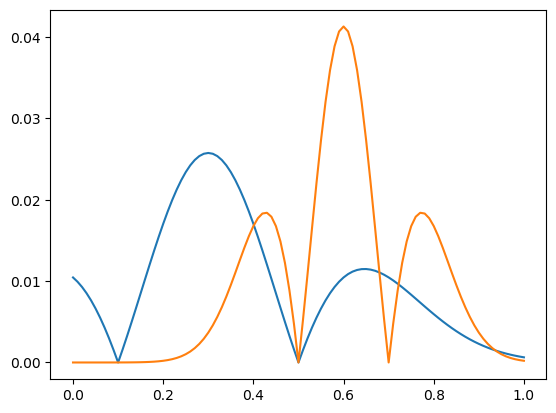

1.0

In [11]:
r = ricker_func(x, 0.3, 0.2)
c = ricker_func(x, 0.6, 0.1)
r = abs.(r)
c = abs.(c)
r = r ./ norm(r,1)
c = c ./ norm(c,1)

plot(x,r,x,c)
norm(c,1)

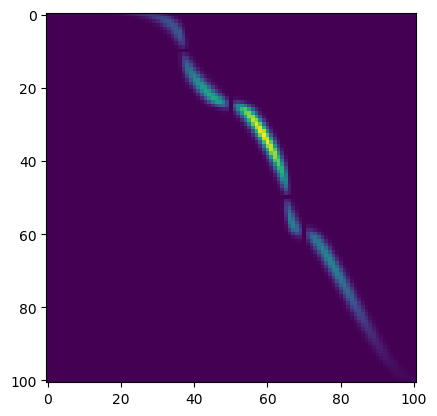

454.7862359108582

In [12]:
# using Python Sinkhorn code
lambd = 6
Gs = ot.sinkhorn(r, c, M, lambd, verbose=true)
imshow(Gs)
sum(Gs .* M)

In [13]:
T, a, d = sinkhorn_basic(r, c, M; lambda=1e-1, numItermax = 4000, stopThr = 1e-8, verbose=true);

Iteration number: 2746
Error: 3.510088440099621e-46


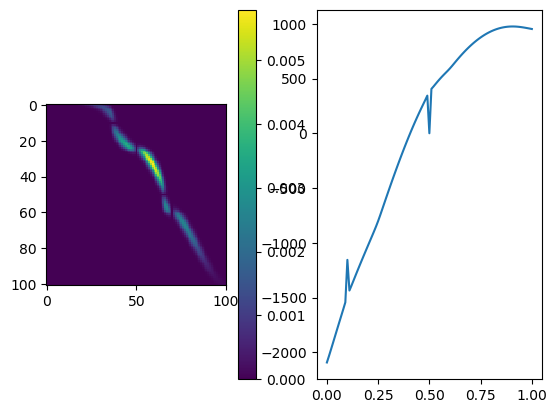

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10412e7710>

In [14]:
figure;
subplot(121); imshow(T); colorbar()
subplot(122); plot(x,a)

## Example for signal

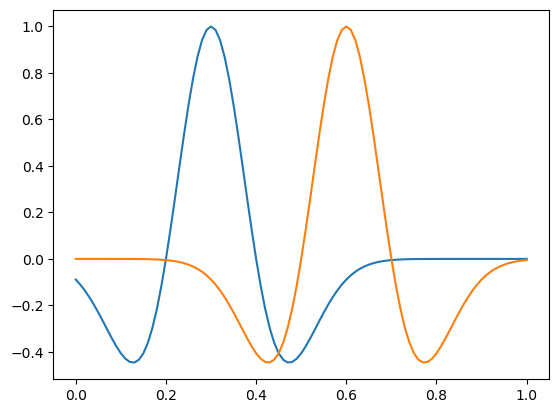

In [15]:
r = ricker_func(x, 0.3, 0.1)
c = ricker_func(x, 0.6, 0.1)

plot(x,r,x,c)

# normalization
cp = zeros(N)
cn = zeros(N)
cp[c .>= 0] = c[c .>= 0]
cn[c .< 0] = c[c .< 0]
cn = abs.(cn)
# for robustness
cp .+= 0.01*maximum(cp)
cn .+= 0.01*maximum(cn)

rp = zeros(N)
rn = zeros(N)
rp[r .>= 0] = r[r .>= 0]
rn[r .< 0] = r[r .< 0]
rn = abs.(rn)
rp .+= 0.01*maximum(cp)
rn .+= 0.01*maximum(cn)

cp = cp ./ norm(cp,1)
cn = cn ./ norm(cn,1)
rp = rp ./ norm(rp,1)
rn = rn ./ norm(rn,1);

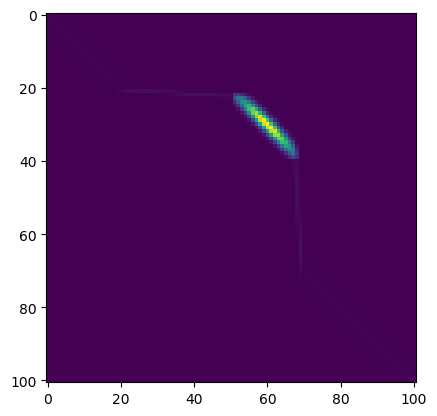

813.9964420411097

In [16]:
# using Python Sinkhorn code
lambd = 5
Gs = ot.sinkhorn(rp, cp, M, lambd, verbose=false)
imshow(Gs)
sum(Gs .* M)

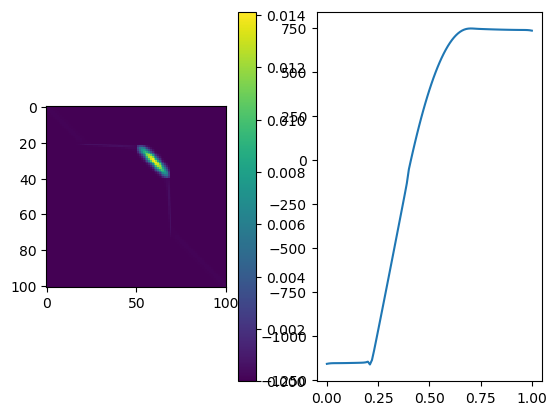

Iteration number: 1000
Error: 3.796065682792494e33


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10440e8160>

In [17]:
Tp, ap, dp = sinkhorn_basic(rp, cp, M; lambda=0.1, numItermax = 1000, stopThr = 1e-7, verbose=true);
figure;
subplot(121); imshow(Tp); colorbar()
subplot(122); plot(x,ap)

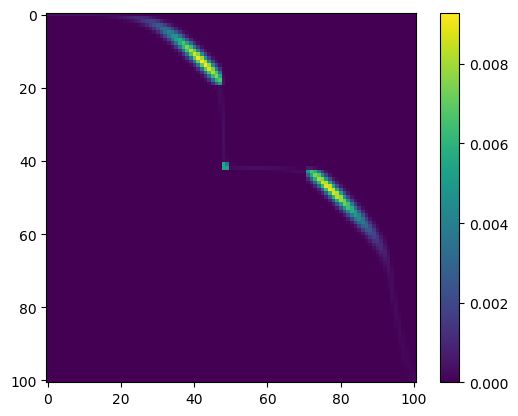

798.735652294097

In [18]:
# positive
# using Python Sinkhorn code
lambd = 5
Gs = ot.sinkhorn(rn,cn, M, lambd, verbose=false)
imshow(Gs); colorbar()
sum(Gs .* M)

## Sinkhorn Function for Signal

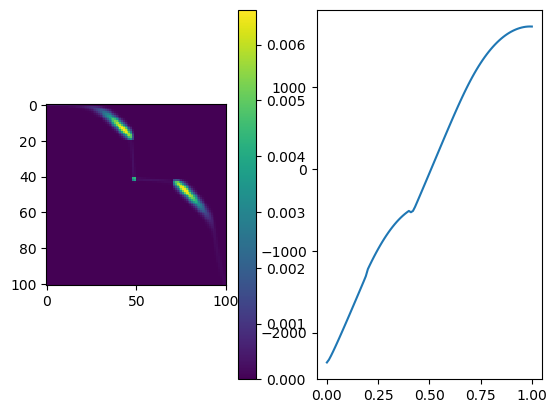

Iteration number: 1000
Error: 5.836366207904865e76


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x104395e780>

In [19]:
Tn, an, dn = sinkhorn_basic(rn, cn, M; lambda=0.1, numItermax = 1000, stopThr = 1e-7, verbose=true);
figure;
subplot(121); imshow(Tn); colorbar()
subplot(122); plot(x,an)

In [20]:
function sinkhorn_signal_1D(r, c, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)
    
    # normalization
    cp = zeros(N)
    cn = zeros(N)
    cp[c .>= 0] = c[c .>= 0]
    cn[c .< 0] = c[c .< 0]
    cn = abs.(cn)
    
    rp = zeros(N)
    rn = zeros(N)
    rp[r .>= 0] = r[r .>= 0]
    rn[r .< 0] = r[r .< 0]
    rn = abs.(rn)

#     normalization
    cp = cp ./ norm(cp,1)
    cn = cn ./ norm(cn,1)
    rp = rp ./ norm(rp,1)
    rn = rn ./ norm(rn,1)

#     compute sinkhorn
    Tp, ap, dp = sinkhorn_basic(rp, cp, M; lambda=lambda, numItermax = numItermax, stopThr = stopThr, verbose=verbose);
    Tn, an, dn = sinkhorn_basic(rn, cn, M; lambda=lambda, numItermax = numItermax, stopThr = stopThr, verbose=verbose);

    T = Tp + Tn;
    a = ap + an;
    d = dp + dn;
    return T, a, d
end

sinkhorn_signal_1D (generic function with 1 method)

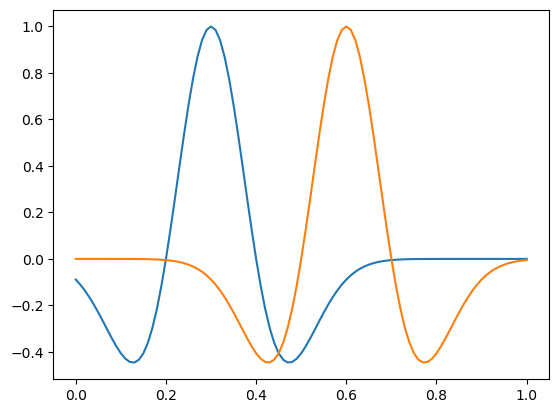

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10439e3b70>
 PyObject <matplotlib.lines.Line2D object at 0x10439e3cc0>

In [21]:
r = ricker_func(x, 0.3, 0.1)
c = ricker_func(x, 0.6, 0.1)

plot(x,r,x,c)

In [22]:
T, a, d = sinkhorn_signal_1D(r, c, M; lambda=0.1, numItermax = 10000, stopThr = 1e-6, verbose=true);

Iteration number: 145
Error: 3.637985745979e-12
Iteration number: 5251
Error: 5.55121041367603e-17


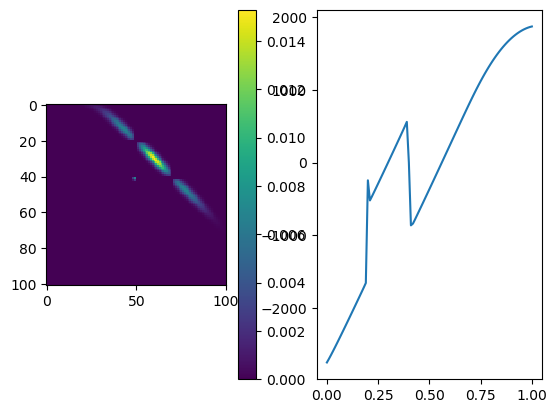

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10441a8080>

In [23]:
figure;
subplot(121); imshow(T); colorbar()
subplot(122); plot(x,a)

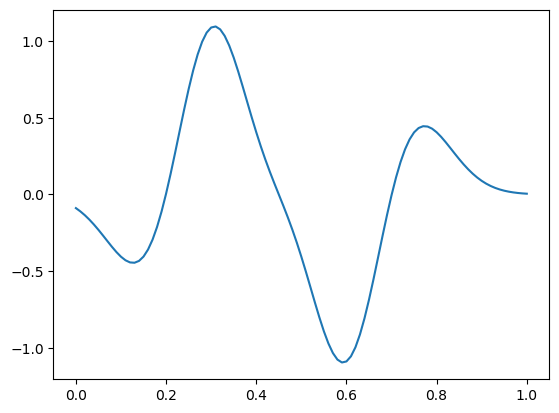

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10444d4780>

In [24]:
plot(x, r-c)

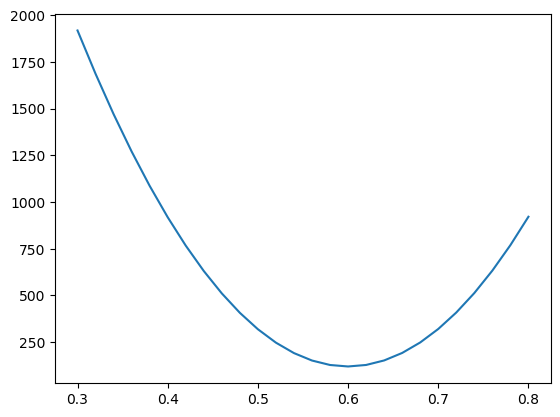

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1043c37588>

In [25]:
c = ricker_func(x, 0.6, 0.1)
misfit = 0.3:0.02:0.8
n = length(misfit)
val = zeros(n)

for i = 1:n
    r = ricker_func(x, misfit[i], 0.05)
    T, a, val[i] = sinkhorn_signal_1D(r, c, M; lambda=0.1, numItermax = 10000, stopThr = 1e-6, verbose=false);
    i
end
plot(misfit, val)